# DSCI 573 lab 2

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd

# classifiers / models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# data
from sklearn import datasets

# other
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
import nltk

## Introduction

The learning objectives of this lab are:
1. to get a taste of feature engineering 
2. to understand regularization better

## Feature engineering

_Feature engineering_ is the process of extracting relevant features so that you can train machine learning models using these features. Better features increase the predictive power of machine learning models. That said, it is a hard and a time-consuming process, which requires domain knowledge. In 571 you used some datasets, e.g., Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset or `sklearn`'s [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), where someone else had extracted features for you. In this exercise, you will extract your own features for a text classification task of classifying whether a given text message is `spam` or `ham` (non-spam). You will be using Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset) for this exercise. Download the CSV. The starter code below opens and loads the data CSV as a pandas DataFrame assuming that the CSV is present at `../../data/spam.csv`. 

**Note:** In this exercise we are not expecting you to demonstrate domain knowledge. That's why we have chosen a problem where all of us have some intuitions about relevant features. (Later in the program you'll learn some methods which do not require feature engineering. You will appreciate these methods a lot more if you go through this process of feature engineering at least once.) 

In [2]:
sms_df = pd.read_csv('../../data/spam.csv', encoding='latin-1')
sms_df = sms_df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms_df = sms_df.rename(columns = {'v1':'target', 'v2':'sms'})

sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knn = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)

In [4]:
classifiers = {'SVC' : svc,
        'KNN' : knn, 
        'NB': mnb, 
        'DT': dtc, 
        'LR': lrc, 
        'RF': rfc
       }

## 1(a) Baseline model

rubric={accuracy:3,quality:1}

As a baseline, build a model that makes a decision about whether a given text message is `spam` or `ham` simply based on the number of words in the text message.   

1. Extract the `length` feature, which is the length of the given text in words. Hint: To get a list of words from the given sentence, you may use the simple `str.split()` function or a more sophisticated [`nltk` tokenizer](https://www.nltk.org/api/nltk.tokenize.html). 
2. Add a new column `length` in the `sms_df` dataframe.
3. Split the dataset into train (70%) and test (30%) sets.
4. Train a `scikit-learn` classifier of your choice with only the `length` feature using the train set. 
5. Report the train and test accuracies of this baseline model.

In [5]:
sms_df['length'] = sms_df['sms'].apply(lambda x: len(nltk.word_tokenize(x)))

In [6]:
feat_set = ['length']
xtrain, xtest, ytrain, ytest = train_test_split(sms_df[feat_set], sms_df['target'], test_size=0.3, random_state=111)
rfc.fit(xtrain,ytrain);
rfc.score(xtrain,ytrain)
rfc.score(xtest,ytest)

0.8582535885167464

## 1(b) Feature engineering

rubric={accuracy:4,quality:2,reasoning:4}

1. Come up with at least four features (other than word count features) that could be relevant for this task. (You will be working with the word count features in 1(c). So please try features other than word counts here.) 
2. Explain the intuition behind each feature. 
3. Implement your features. 
4. Run your model with these features. 
5. Do you see any improvement in the accuracy over the baseline? 

**Note:** It's great if you find features that give you better results. But the grades won't be decided based on whether your features give the best accuracy or not. It's alright if your features don't always improve the accuracy.   

In [7]:
def get_avg_word_length(text):
    """
    Returns the average word length of the given text. 
    
    Keyword arguments:
    text -- (str) 
    """
    words = text.split()
    return sum(len(word) for word in words)/len(words)

In [8]:
import string
def count_punctuations(text):
    """
    Returns the number of punctuation marks in the given text. 
    
    Keyword arguments:
    text -- (str)             
    """
    npunct = 0
    punct_list = [p in string.punctuation for p in list(text)]
    return punct_list.count(True)        

In [9]:
def presence_of_numbers(text):
    """
    Returns whether the given text contains numbers or not. 
    
    Keyword arguments:
    text -- (str)             
    """
    import re
    if re.search(r'\d+', text):
        return True
    return False

In [10]:
# Possible features
# 1. presence of currency symbols
# 2. presence of ellipsis

In [11]:
# Intuition: Spam messages tend to be longer with complex and long words. 
sms_df['char_length'] = sms_df['sms'].apply(len)
sms_df['average_word_length'] = sms_df['sms'].apply(get_avg_word_length)

# Intuition: Spam messages tend to use more punctuation marks (this can be an effect of length too). 
sms_df['npunct'] = sms_df['sms'].apply(count_punctuations)

# Intuition: Spam messages tend to contain more numbers. 
sms_df['presence_of_numbers'] = sms_df['sms'].apply(presence_of_numbers)
#sms_df['n_spell_errors'] = sms_df['sms'].apply(count_spelling_errors)

In [12]:
feat_set = ['length', 'char_length', 'average_word_length', 'npunct', 'presence_of_numbers']
xtrain, xtest, ytrain, ytest = train_test_split(sms_df[feat_set], sms_df['target'], test_size=0.3, random_state=111)
rfc.fit(xtrain,ytrain);
print('Train accuracy: ', rfc.score(xtrain,ytrain))     
print('Test accuracy: ', rfc.score(xtest,ytest))
      

Train accuracy:  0.9984615384615385
Test accuracy:  0.9629186602870813


### 1(c) 

rubric={accuracy:3,reasoning:2}

1. Turn the data into a sparse vector of word frequency counts using `scikit-learn`'s [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). In particular, 
   1. Split the data into train (70%) and test (30%) portions.
   2. Create a `CountVectorizer` object.
   3. Call `CountVectorizer`'s `fit` method on the train split.
   4. Call `CountVectorizer`'s `transform` method on the train split.
   5. Call `CountVectorizer`'s `transform` method on the test split.
2. Fit a model using the same classifier you used in 1(a) with these word count features. 
3. Report the train and test accuracies with these features. Compare these results with the results you got in 1(b). 
4. Would you get better accuracy if you combine these features with the features from 1(b)? 

#### Solution

In [13]:
# For tokenization
import nltk
from sklearn.feature_extraction.text import CountVectorizer

xtrain, xtest, ytrain, ytest = train_test_split(sms_df['sms'], sms_df['target'], test_size=0.3, random_state=111)

sms_vec = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, stop_words='english')
Xtrain_counts = sms_vec.fit_transform(xtrain)
Xtest_counts = sms_vec.transform(xtest)

In [14]:
rfc.fit(Xtrain_counts,ytrain);
print('Train accuracy: ', rfc.score(Xtrain_counts,ytrain))
print('Test accuracy: ', rfc.score(Xtest_counts,ytest))     

Train accuracy:  0.9992307692307693
Test accuracy:  0.9760765550239234


We get a slightly better test accuracy with the word count features. It is possible that we get better accuracy if we combine features from 1(b) and 1(c) if the features are complementary. But this needs to be tested empirically. 

### (Optional) 1(d) 

rubric={reasoning:1}

1. Preprocess the text data so that the extracted features are meaningful and accurate. For example, before extracting features, 
    * tokenize the text using [`nltk` tokenizer](https://www.nltk.org/api/nltk.tokenize.html). 
    * convert the text into lower case.   
2. Combine the features from 1(b) and 1(c). 
3. You may use [`scikit-learn` pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for 1. and 2.
4. Carry out feature selection using any method of your choice. 
5. Discuss your results. 

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def text_feats_pipeline():
    '''
    :return:
    '''
    # Create feature pipelines and then feature unions
    # ngram and tf-idf features
    text = Pipeline([
        ('selector', TextSelector(key='sms')),
        ('ngrams', CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, stop_words='english'))
        #('tfidf', TfidfTransformer())
    ])
    return text

def length_feats_pipeline():
    '''
    #:return:
    '''
    # Length features
    length = Pipeline([
        ('selector', NumberSelector(key='length')),
        ('standard', StandardScaler())
    ])

    
    length_in_chars = Pipeline([
        ('selector', NumberSelector(key='char_length')),
        ('standard', StandardScaler())
    ])

    average_word_length = Pipeline([
        ('selector', NumberSelector(key='average_word_length')),
        ('standard', StandardScaler())
    ])

    length_feats = FeatureUnion([
        ('length', length),
        ('length_in_chars', length_in_chars),        
        ('average_word_length', average_word_length),
    ])

    return length_feats
    
def other_feats_pipeline():
    '''
    #:return:
    '''
    # Other features
    presence_of_nums = Pipeline([
        ('selector', NumberSelector(key='presence_of_numbers')),
        ('standard', StandardScaler())
    ])

    npunct = Pipeline([
        ('selector', NumberSelector(key='npunct')),
        ('standard', StandardScaler())
    ])

    other_feats = FeatureUnion([
        ('presence_of_nums', presence_of_nums),
        ('npunct', npunct),
    ])

    return other_feats    
    
def build_feature_pipelines_and_unions(feature_set = ['text_feats', 'length_feats'
                                                     'other_feats']):
    text_feats = text_feats_pipeline()
    length_feats = length_feats_pipeline()
    other_feats = other_feats_pipeline()

    feat_sets_dict = {
                      'text_feats': text_feats,
                      'length_feats': length_feats,
                      'other_feats': other_feats
                     }

    feat_tuples = [(feat, feat_sets_dict[feat]) for feat in feature_set]
    feats = FeatureUnion(feat_tuples)
    return feats 

In [17]:
def report_train_test_accuracies(features):
    """
    """
    print('Feature set: ', features)
    feats = build_feature_pipelines_and_unions(features)
    pipeline = Pipeline([
                    ('features', feats),
                    ('classifier', rfc),
                ])

    pipeline.fit(xtrain,ytrain);
    print('Train accuracy: ', pipeline.score(xtrain,ytrain))
    print('Test accuracy: ', pipeline.score(xtest,ytest))
    print('----------------')

In [18]:
# Split data
columns = ['sms', 'length', 'char_length', 'average_word_length', 'npunct', 'presence_of_numbers']
sms_df['length'] = sms_df['length'].astype(float)
sms_df['char_length'] = sms_df['char_length'].astype(float)
sms_df['average_word_length'] = sms_df['average_word_length'].astype(float)
sms_df['npunct'] = sms_df['npunct'].astype(float)
sms_df['presence_of_numbers'] = sms_df['presence_of_numbers'].astype(float)

xtrain, xtest, ytrain, ytest = train_test_split(sms_df[columns], sms_df['target'], test_size=0.3, random_state=111)

report_train_test_accuracies(['text_feats'])
report_train_test_accuracies(['length_feats'])
report_train_test_accuracies(['other_feats'])
report_train_test_accuracies(['text_feats', 'length_feats', 'other_feats'])

Feature set:  ['text_feats']
Train accuracy:  0.9992307692307693
Test accuracy:  0.9760765550239234
----------------
Feature set:  ['length_feats']
Train accuracy:  0.9912820512820513
Test accuracy:  0.9258373205741627
----------------
Feature set:  ['other_feats']
Train accuracy:  0.8938461538461538
Test accuracy:  0.8785885167464115
----------------
Feature set:  ['text_feats', 'length_feats', 'other_feats']
Train accuracy:  0.9997435897435898
Test accuracy:  0.9832535885167464
----------------


**Discussion:**
As we can see in the results shown above, we get better test accuracy when we combine word count features with length and other features. 

## Exercise 2: Regularized logistic regression

rubric={accuracy:4,quality:2,reasoning:4}

In this exercise, you will explore logistic regression with `L1` and `L2` regularization. You will be using the dataset "logisticData.pkl" from the [`data`](../../data) directory of this course's `*_student` repository. The starter code to load the data is given below.  

1. Use `scikit-learn`'s [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to compare `L1` and `L2` regularization. 
2. In each case, report the number of "selected features" and the validation error with $C = 1$ ($C$ is the reciprocal of the regularization parameter). 
3. Discuss your results.

Note: to determine if a feature was "selected" or not, check if the corresponding element of $w/\max(w)$ is above some small threshold like $10^{-6}$, where $w$ are the weights.

*Clarification on the discussion aspect: you are to compare the `L1` and `L2` regularization results with a common $C=1$ regularization parameter (for example, how do the coefficient estimates compare in both cases?).*

In [19]:
# BEGIN STARTER CODE
np.random.seed(0)

data = pd.read_pickle("../../data/logisticData.pkl")

C = 1e10

X = data['X']
y = data['y']

Xvalidate = data['Xvalidate']
yvalidate = data['yvalidate']
# END STARTER CODE

### Solution

In [20]:
train_scores = list()
val_scores = list()
selected_features = list()
index = list()

# Set some threshold
threshold = 1e-6

lr_l1 = LogisticRegression(max_iter=400, C=1, penalty = 'l1')
lr_l2 = LogisticRegression(max_iter=400, C=1, penalty = 'l2')

# A dictionary to hold the estimators
classifiers = {
                'LogisticRegression (L1)': lr_l1,
                'LogisticRegression (L2)': lr_l2
              }

for classifier_name, classifier_obj in classifiers.items():
    classifier_obj.fit(X, y)
    train_scores.append(classifier_obj.score(X, y))
    val_scores.append(classifier_obj.score(Xvalidate, yvalidate))
    index.append(classifier_name)
    norm_features = np.abs(classifier_obj.coef_[0])/np.max(np.abs(classifier_obj.coef_[0]))
    features = np.where(norm_features > threshold)[0]
    selected_features.append(features)

df = pd.DataFrame(train_scores, index = index, columns=['Train score'])
df['Validation score'] = val_scores
df['Selected features'] = selected_features
df['#Features'] = [len(val) for val in selected_features]
df

/Users/kvarada/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kvarada/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,Train score,Validation score,Selected features,#Features
LogisticRegression (L1),1.000,0.948,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 16, 17...",71
LogisticRegression (L2),0.998,0.926,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",101


<span style="color:blue">$\ell^1$ regularized logistic regression performs best (as evidenced by its higher validation score). It also selects a subset of the features wheres ridge keeps all the features. This suggests that some features are not strong predictors of the response. Thus, ridge regression may be overfitting on the unimportant predictors by assigning them non-zero weights.  

<span style="color:blue">**The rest of this solution is optional/extra info:**
    
<span style="color:blue">In ordinary least squares, 

<span style="color:blue">$$
\displaystyle \hat w = {\arg\min}_{w \in \mathbb R^d} \|Xw - y\|_2
$$

<span style="color:blue">The solution is given by solving the linear system $X^TX\hat{w}=X^Ty$.

<span style="color:blue">$\hat w = (X^T X)^{-1} X^T y=X^\dagger y$ when the matrix $X$ has full column rank (a solution cannot be defined in this way if $X$ does not have full column-rank, because $X^T X$ will not be invertible). "$X$ has full column rank" is the same as saying that the system is overdetermined, which is the same as saying that there are more samples than features. In this case, the so-called *normal matrix* $X^T X$ that appears in the *pseudoinverse* $X^\dagger$ may be poorly conditioned. This means that $(X^T X)^{-1}$ may behave erratically in the sense that we cannot expect nice behaviour from our $\hat w$, which means that the value of $\hat w$ could be sensitive to the training data. Regularization helps solve this problem by ensuring that the pseudoinverse $X^\dagger$ is *well-conditioned* so that $\hat w = X^\dagger y$ behaves nicely (*i.e.* is not overly sensitive to training data). __Suggestion: Regularization helps solve this problem by computing a nicely-behaved $\hat w=X^* y$ based on some relevant but *well-conditioned* $X^*$ (*i.e.* is not overly sensitive to training data). The regularization does not change $X^\dagger$.__   
<br />
In contrast, if the system is underdetermined (*i.e.*, we have more features than observations) then this matrix $X^T X$ is not even invertible, so we cannot compute $X^\dagger$. However, $Xw = y$ now has infinitely many solutions (because there are more variables/features than constraints/samples); it so happens that regularization *constrains* the algorithm so that of the infinitely many possible solutions $\hat w$ it takes the one that best satisfies the constraint function (*e.g.*, choose $\hat w$ with least $\ell^2$ norm). All of this intuition translates pretty much directly to fancier models (like logistic regression).  
<br />
A final caveat: the scaling between different regularizations may not always be the same (there may be a different natural scaling for the constant of ridge vs. lasso), hence, it may be necessary to optimize over the parameter `C` to determine the best model.</span>

### Exercise 3: RBF and regularization

In this exercise you will use the `nonLinearDataS` dataset from the [`data`](../../data) directory of this course's `*_student` repository. The starter code is given below, which loads the dataset and performs kernel ridge regression (least squares with a kernel function and `L2` regularization). It plots the result and prints out a performance metric. The performance of the model becomes better as the `RBF` parameter `gamma` is increased, but substantially overfits for very high values. We might expect to do better through the use of regularization. 

Text(0.5,1,'Test score: 0.528248 (best=1.0)')

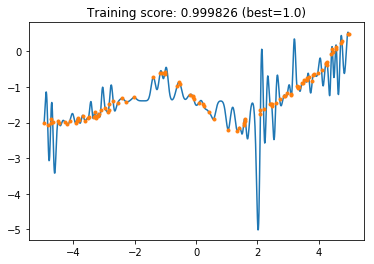

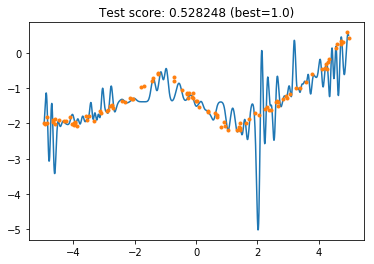

In [21]:
# BEGIN STARTER CODE
from sklearn.svm import SVR
# Note: we use SVR instead of sklearn.kernel_ridge.KernelRidge because KernelRidge 
# doesn't expose the regularization parameter
# But by setting epsilon=0 below, we basically reproduce the behavior of KernelRidge.

data = pd.read_pickle("../../data/nonLinearDataS.pkl")    
    
X = data['X'][:,None]
y = data['y']#[:,None]
Xtest = data['Xtest'][:,None]
ytest = data['ytest']#[:,None]

# note: larger gamma means more complexity; larger C means higher penalty for misclassification (less regularization)
kr = SVR(epsilon=0, kernel="rbf", gamma=100, C=1000)
kr.fit(X, y) 

grid = np.linspace(np.min(X),np.max(X),1000)[:,None]
grid_pred = kr.predict(grid)
plt.plot(grid, grid_pred)
plt.plot(X, y, '.')
plt.title("Training score: %f (best=1.0)" % kr.score(X, y))

plt.figure()
plt.plot(grid, grid_pred)
plt.plot(Xtest, ytest, '.')
plt.title("Test score: %f (best=1.0)" % kr.score(Xtest, ytest))
# END STARTER CODE

#### 3(a)

rubric={accuracy:4,quality:2}

Examine whether you can achieve a lower test error by exploring different values of the regularization parameter $\lambda$ (in the code, we control this through the parameter `C`, which is $\frac{1}{\lambda}$). Try `C` in the range: $10^{-4},10^{-3},..., 10{^4}$.

### Solution
<span style="color:blue">  Let us observe the training and test scores over  a range of $C$ values.</span>

            Training score  Test score
C: 0.0001        -0.058800   -0.010428
C: 0.001         -0.053110   -0.006513
C: 0.01           0.002942    0.032140
C: 0.1            0.455099    0.356204
C: 1.0            0.998112    0.923453
C: 10.0           0.998987    0.919779
C: 100.0          0.999465    0.850533
C: 1000.0         0.999826    0.528248
C: 10000.0        1.000000   -0.057205


<Figure size 432x288 with 0 Axes>

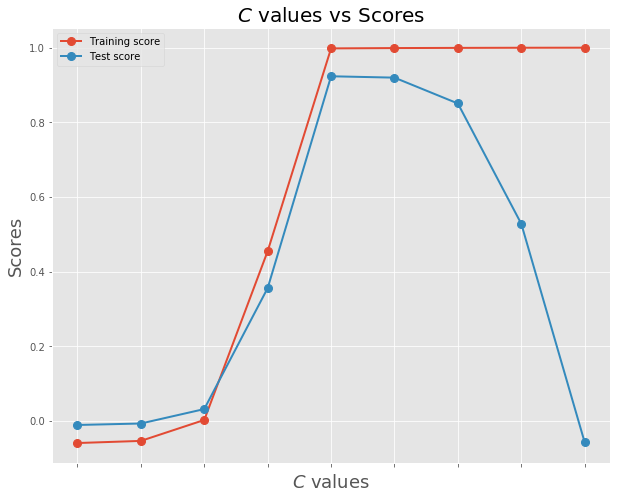

In [22]:
C_range = np.arange(-4.0, 5.0)
data = np.zeros((C_range.shape[0],2))
index = ['C: '+ i for i in map(str,10**C_range)]

for idx, val in enumerate(C_range):
    kr = SVR(epsilon=0, kernel="rbf", gamma=100, 
             C=10**val)
    kr.fit(X, y) 
    data[idx,0] = kr.score(X,y)
    data[idx,1] = kr.score(Xtest,ytest)
df = pd.DataFrame(data, index = index, 
                  columns=['Training score', 'Test score'])
print(df)

%matplotlib inline

# Plot the results
plt.style.use('ggplot')
plt.figure() 
df.plot(style='o-', ms=8, lw=2, figsize = (10, 8))
plt.xlabel('$C$ values', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('$C$ values vs Scores', fontsize=20)
plt.legend(loc="best")

#### 3(b)

rubric={accuracy:4,quality:2,reasoning:2}

Unfortunately, this demo and exploring whether we can achieve a better test error by trying out different values of $\lambda$ is violating the golden rule of machine learning, by looking at the test set multiple times. In this exercise let's try to do it properly. 

1. Instead of training on the full training set and testing on the test set, train on the first half of the training data and test on the second half of the training data (the validation set). 
2. Compare the test error to the result from Exercise 3(a).
3. Then, try again but this time shuffling the data set first (or, equivalently, doing a random split). 
4. Are the results different?

*** TRAINING on half of the dataset
            Training score  Validation score  Test score
C: 0.0001        -0.108460         -0.995869   -0.010428
C: 0.001         -0.100693         -0.994590   -0.006513
C: 0.01          -0.018172         -0.969492    0.032140
C: 0.1            0.522788         -0.822956    0.356204
C: 1.0            0.996457         -0.581339    0.923453
C: 10.0           0.997228         -0.580857    0.919779
C: 100.0          0.998659         -0.624239    0.850533
C: 1000.0         0.999224         -0.618240    0.528248
C: 10000.0        1.000000         -0.311099   -0.057205


<Figure size 432x288 with 0 Axes>

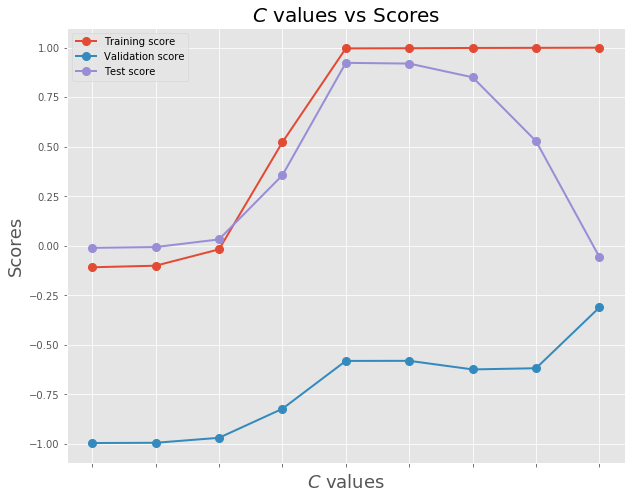

In [23]:
print("*** TRAINING on half of the dataset")
D = X.shape[0]
Ntrain = int(D/2)
Xtrain = X[0:Ntrain,:]
ytrain = y[0:Ntrain]
Xvalid = X[Ntrain:,]
yvalid = y[Ntrain:,]

C_range = np.arange(-4.0,5.0)
data = np.zeros((C_range.shape[0], 3))
index = ['C: '+ i for i in map(str,10**C_range)]

for idx, val in enumerate(C_range):
    kr = SVR(epsilon=0, kernel="rbf", gamma=100, 
             C=10**val)
    kr.fit(Xtrain, ytrain) 
    data[idx,0] = kr.score(Xtrain,ytrain)
    data[idx,1] = kr.score(Xvalid,yvalid)
    kr.fit(X, y) 
    data[idx,2] = kr.score(Xtest,ytest)
    
df = pd.DataFrame(data, index = index, 
                  columns=['Training score', 
                           'Validation score', 
                           'Test score'])
print(df)

%matplotlib inline

# Plot the results
plt.style.use('ggplot')
plt.figure() 
df.plot(style='o-', ms=8, lw=2, figsize = (10, 8))
plt.xlabel('$C$ values', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('$C$ values vs Scores', fontsize=20)
plt.legend(loc="best")

<span style="color:blue"> The validation error is a poor approximation of the test error. Let's shuffle the data and see if it changes anything. </span>

*** TRAINING on half of the dataset after shuffling the data
            Training score  Validation score  Test score
C: 0.0001        -0.031076         -0.001608   -0.010428
C: 0.001         -0.027885          0.000687   -0.006513
C: 0.01           0.004891          0.023047    0.032140
C: 0.1            0.263530          0.223688    0.356204
C: 1.0            0.974746          0.822162    0.923471
C: 10.0           0.999981          0.838394    0.919870
C: 100.0          1.000000          0.827152    0.850542
C: 1000.0         1.000000          0.827152    0.528780
C: 10000.0        1.000000          0.827152   -0.058308


<Figure size 432x288 with 0 Axes>

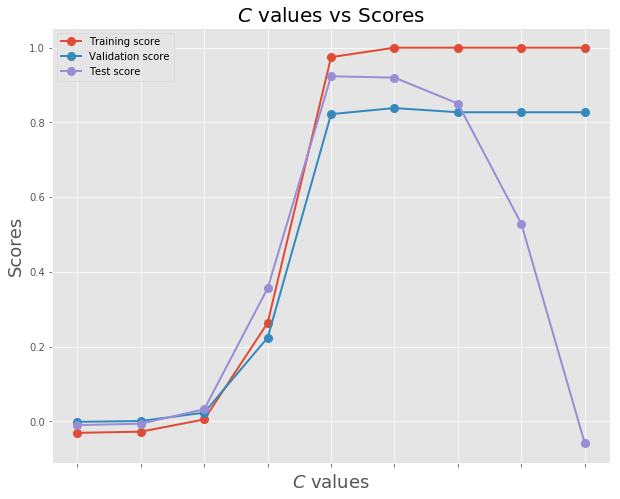

In [24]:
print("*** TRAINING on half of the dataset after shuffling the data")
D = X.shape[0]
from sklearn.utils import shuffle
Xshuffled, yshuffled = shuffle(X, y, random_state=4321)

Ntrain = int(D/2)
Xtrain = Xshuffled[0:Ntrain,:]
ytrain = yshuffled[0:Ntrain]
Xvalid = Xshuffled[Ntrain:,]
yvalid = yshuffled[Ntrain:,]

C_range = np.arange(-4.0,5.0)
data = np.zeros((C_range.shape[0], 3))
index = ['C: '+ i for i in map(str,10**C_range)]

for idx, val in enumerate(C_range):
    kr = SVR(epsilon=0, kernel="rbf", gamma=100, 
             C=10**val)
    kr.fit(Xtrain, ytrain) 
    data[idx,0] = kr.score(Xtrain,ytrain)
    data[idx,1] = kr.score(Xvalid,yvalid)
    kr.fit(Xshuffled, yshuffled) 
    data[idx,2] = kr.score(Xtest,ytest)
    
df = pd.DataFrame(data, index = index, 
                  columns=['Training score', 
                           'Validation score', 
                           'Test score'])
print(df)

%matplotlib inline

# Plot the results
plt.style.use('ggplot')
plt.figure() 
df.plot(style='o-', ms=8, lw=2, figsize = (10, 8))
plt.xlabel('$C$ values', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('$C$ values vs Scores', fontsize=20)
plt.legend(loc="best")

<span style="color:blue">The validation error now is a better approximation of the test error compared to the previous one. This implies that our data has had some kind of structure in it causing either the first or the second half of the data used for training or validation to not be a good representation of the whole data.</span>  

<span style="color:blue">Still we have the problem that the validation set does not provide  the best 'C' for the test set. This can be due to the small size of the training set. Let's increase the size of the training set.</span>

*** TRAINING on 3/4 of the dataset after shuffling the data
            Training score  Validation score  Test score
C: 0.0001        -0.062794         -0.016872   -0.010428
C: 0.001         -0.058261         -0.013132   -0.006513
C: 0.01          -0.013878          0.023542    0.032140
C: 0.1            0.375598          0.348747    0.356204
C: 1.0            0.998532          0.829516    0.923471
C: 10.0           0.999291          0.815952    0.919870
C: 100.0          0.999922          0.700773    0.850542
C: 1000.0         1.000000          0.607027    0.528780
C: 10000.0        1.000000          0.607027   -0.058308


<Figure size 432x288 with 0 Axes>

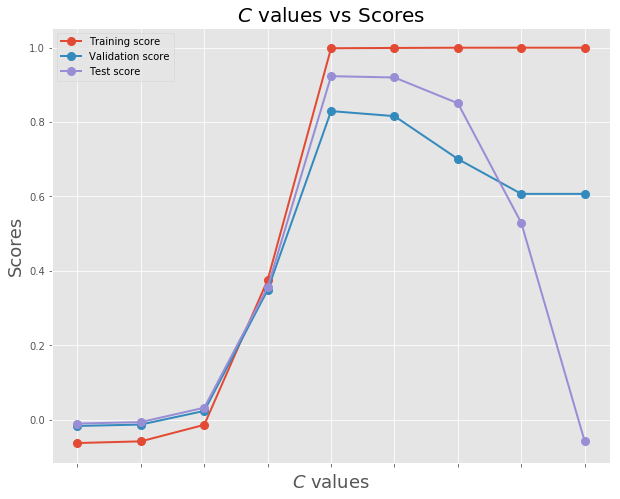

In [25]:
print("*** TRAINING on 3/4 of the dataset after shuffling the data")
      
D = X.shape[0]
Ntrain = int(3*D/4)
Xtrain = Xshuffled[0:Ntrain,:]
ytrain = yshuffled[0:Ntrain]
Xvalid = Xshuffled[Ntrain:,]
yvalid = yshuffled[Ntrain:,]

C_range = np.arange(-4.0,5.0)
data = np.zeros((C_range.shape[0], 3))
index = ['C: '+ i for i in map(str,10**C_range)]

for idx, val in enumerate(C_range):
    kr = SVR(epsilon=0, kernel="rbf", gamma=100, 
             C=10**val)
    kr.fit(Xtrain, ytrain) 
    data[idx,0] = kr.score(Xtrain,ytrain)
    data[idx,1] = kr.score(Xvalid,yvalid)
    kr.fit(Xshuffled,yshuffled)
    data[idx,2] = kr.score(Xtest,ytest)
    
df = pd.DataFrame(data, index = index, 
                  columns=['Training score', 
                           'Validation score', 
                           'Test score'])
print(df)

%matplotlib inline

# Plot the results
plt.style.use('ggplot')
plt.figure() 
df.plot(style='o-', ms=8, lw=2, figsize = (10, 8))
plt.xlabel('$C$ values', fontsize=18)
plt.ylabel('Scores', fontsize=18)
plt.title('$C$ values vs Scores', fontsize=20)
plt.legend(loc="best")

<span style="color:blue">We can see that the scores from the larger and shuffled validation set more closely resemble those of the test set. Thus, when there is order in the data it is important to shuffle it before the train-validation split, and in general it is also important to choose a large enough training set to get a model that generalizes well. Another approach that would also work well here would be to perform k-fold cross-validation with random assignment of observations into each of the k-folds.

#### 3(c)

rubric={accuracy:4,quality:2,viz:4}

1. Search over the hyperparameters `gamma` and `C` and find a combination that performs the best on the validation set.  
2. Once you have the best values of the hyperparameters `gamma` and `C`, train on the full training set and compute the performance score on the test set. 
3. Report the best values of `gamma` and `C` and the final test error estimate from this procedure. 
4. Also include a plot of the fit.

### Solution

*** TRAINING on 3/4 of the dataset
  --> The best parameters are {'C': 1.0, 'gamma': 2.782559402207126} with a score of 0.99
  --> Training score (full training set): 0.992655
  --> Test score: 0.985322


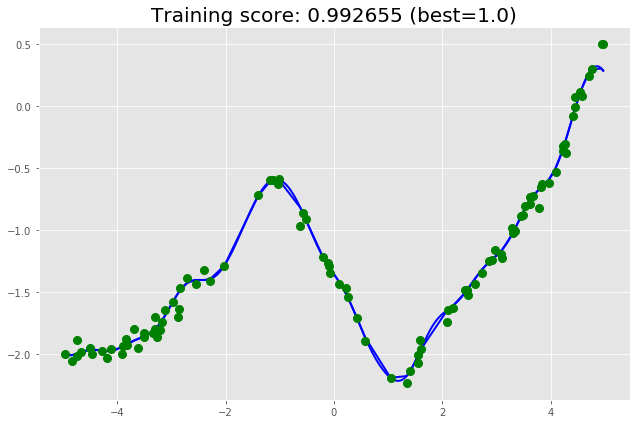

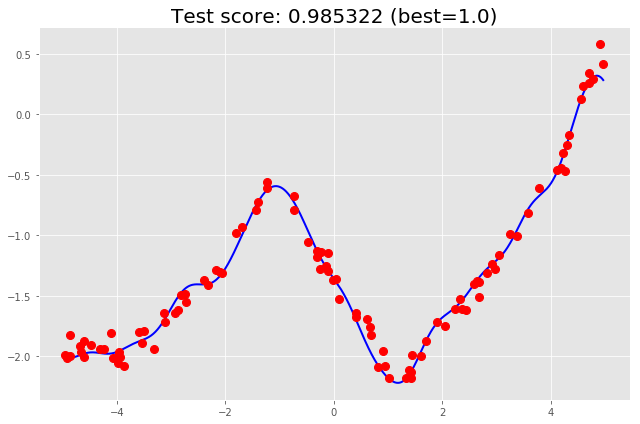

In [26]:
print("*** TRAINING on 3/4 of the dataset")

D = X.shape[0]
#Ntrain = int(3*D/4)
#Xtrain = Xshuffled[0:Ntrain,:]
#ytrain = yshuffled[0:Ntrain]
#Xvalid = Xshuffled[Ntrain:,]
#yvalid = yshuffled[Ntrain:,]

# Search over some pre-defined gamma and C values
C = np.power(10, np.arange(-4.0, 4.0))
gamma = np.logspace(-4.0, 4.0, 10)
param_grid = dict(gamma=gamma, C=C)

# Invoke GridSearchCV, which is an exhaustive search 
# over C and gamma values for SVR.

# default 3 folds cross-validation
#grid = GridSearchCV(SVR(epsilon=0, kernel="rbf"), 
#                    param_grid=param_grid)
# validation against 1/4 of the training data
grid = GridSearchCV(SVR(epsilon=0, kernel="rbf"), 
                    param_grid=param_grid,
                    cv=[(np.arange(0,3*D/4).astype(int),np.arange(3*D/4,D).astype(int))])

grid.fit(Xshuffled, yshuffled)
print("  --> The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


# Train on full training set
kr = SVR(epsilon=0, kernel="rbf", gamma=grid.best_params_['gamma'], 
         C=grid.best_params_['C'])
kr.fit(X, y)

# Report training and test scores
print("  --> Training score (full training set): {0:4f}"
      .format(kr.score(X, y)))
print("  --> Test score: {0:4f}".format(kr.score(Xtest, ytest)))


# Plot the results
plt.style.use('ggplot')
grid = np.linspace(np.min(X), np.max(X), 1000)[:,None]
grid_pred = kr.predict(grid)
plt.plot(grid, grid_pred, color='b', lw=2)
plt.plot(X, kr.predict(X), color='b', lw=2)
plt.plot(X, y, 'o', markersize=8, color='g')
plt.title("Training score: %f (best=1.0)" % kr.score(X, y), 
          fontsize = 20)
plt.gcf().set_size_inches(9, 6)
plt.tight_layout()

plt.figure()

grid = np.linspace(np.min(Xtest), np.max(Xtest), 1000)[:,None]
grid_pred = kr.predict(grid)
plt.plot(grid, grid_pred, color='b', lw=2)
plt.plot(Xtest, ytest, 'o', markersize=8, color='r', lw=1)
plt.title("Test score: %f (best=1.0)" % kr.score(Xtest, ytest), 
          fontsize = 20)
plt.gcf().set_size_inches(9, 6)
plt.tight_layout()


#### (Optional) 3(d)

rubric={reasoning:1}

In DSCI 571 you played around with the `C` and `gamma` parameters of the SVM. Are the interpretations of these parameters the same as here? You'll notice that the RBF makes an appearance in both cases. Write a couple sentences making a connection between these parameters with the same names appearing in two different contexts. 

In DSCI 571, we played around with these parameters and examined them with respect to the fundamental tradeoff of ML and noted that increasing both `C` or `gamma` values leads to overfitting. Now we understand that the `C` parameter is the penalty parameter of the error term and controls the model complexity and the `gamma` parameter determines how much influence a single training example has.